In [1]:
%load_ext autoreload 
%autoreload 2 

In [2]:
import random
import os
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec # for subplots
import pandas as pd
import numpy as np
import seaborn as sns
import seaborn.objects as so
import tensorflow as tf

from src.utilities.plot_helpers import generate_random_colors
from src.modeling.experiments.binned_trial_experiment_01 import split_data

from src.utilities.pandas_helpers import get_features

2023-07-10 16:27:12.481146: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-10 16:27:12.553955: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-10 16:27:16.539528: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Experimental conditions: 
* 2 layer LSTM 
* trained with 128 units

#### Load Model

In [5]:


DATA_PATH = '/projects/p31961/gaby_data/aggregated_data/data_pipeline_full_dataset/datasets/full_dataset.parquet.gzip'
PATH_TO_MODELS = '/projects/p31961/ENIGMA/results/experiments/binned_trial_experiment_01/models'
control_path = os.path.join(PATH_TO_MODELS, 'control')
no_bins_path = os.path.join(PATH_TO_MODELS, 'dropped_binned_trials')


control_model = tf.keras.models.load_model(control_path)
dropped_bins_model = tf.keras.models.load_model(no_bins_path)
control_model.compile()
dropped_bins_model.compile()


models = [control_model, dropped_bins_model]

2023-07-10 16:27:50.751810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_2_grad_concat_split_2_split_dim' with dtype int32
	 [[{{node gradients_split_2_grad_concat_split_2_split_dim}}]]
2023-07-10 16:27:50.751920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients_split_grad_concat_split_split_dim' with dtype int32
	 [[{{node gradients_split_grad_concat_split_split_dim}}]]
2023-07-10 16:27:50.751991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

# Model Summary

In [6]:
for model in models:
    print(model.summary())

Model: "stacked_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Lambda_1 (Lambda)           multiple                  0         
                                                                 
 LSTM_1 (LSTM)               multiple                  66560     
                                                                 
 LSTM_2 (LSTM)               multiple                  131584    
                                                                 
 Dense_output (Dense)        multiple                  129       
                                                                 


Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
_________________________________________________________________
None
Model: "stacked_lstm_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Lambda_1 (Lambda)           multiple                  0         
                                                                 
 LSTM_1 (LSTM)               multiple                  66560     
                                                                 
 LSTM_2 (LSTM)               multiple                  131584    
                                                                 
 Dense_output (Dense)        multiple                  129       
                                                                 
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
_________________________________________________________________
None


#### load training and testing data

In [7]:
data= pd.read_parquet(DATA_PATH)
data.head()

,time,mouse_id,sex_M,day,trial,learning_phase,event_cue,event_escape,event_avoid,latency,event_shock,sensor_D1,sensor_D2,sensor_DA,signal
0,-25.000000,12,0,5,0,0,1,0,0,0.0,0,0,1,0,-0.155359
1,-24.901531,12,0,5,0,0,1,0,0,0.0,0,0,1,0,-0.420553
2,-24.803064,12,0,5,0,0,1,0,0,0.0,0,0,1,0,-1.592294
3,-24.704596,12,0,5,0,0,1,0,0,0.0,0,0,1,0,-1.268734
4,-24.606127,12,0,5,0,0,1,0,0,0.0,0,0,1,0,-0.210176


In [8]:
# split data for control
target='signal'
control_features = get_features(data, target)
no_bin_features = control_features.copy()
no_bin_features.remove('learning_phase')

X_train, y_train, X_val, y_val, X_test, y_test = split_data(data, control_features, target, day_cut_off=6, feature_to_drop=None)

    # split data for dropped binned trials
X_train_dropped, y_train_dropped, X_val_dropped, y_val_dropped, X_test_dropped, y_test_dropped = split_data(
data, no_bin_features, target, day_cut_off=6, feature_to_drop='learning_phase')

In [9]:
y_control_pred = control_model.predict(X_test)
y_dropped_pred = dropped_bins_model.predict(X_test_dropped)

2023-07-10 16:28:27.147013: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,14]
	 [[{{node inputs}}]]
2023-07-10 16:28:28.257182: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600


   83/24887 [..............................] - ETA: 46s   

Could not load symbol cublasGetSmCountTarget from libcublas.so.11. Error: /home/mds8301/.conda/envs/enigma/lib/libcublas.so.11: undefined symbol: cublasGetSmCountTarget


24887/24887 [==============================] - 47s 2ms/step


2023-07-10 16:29:49.439573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,13]
	 [[{{node inputs}}]]


24887/24887 [==============================] - 46s 2ms/step


# Full dataset

## Validation check

In [18]:
full_test_data= X_test.assign(predicted_signal= y_control_pred,
                                              true_signal=y_test)
test_data_query = full_test_data.query("sex_M==1 & event_cue==1 & sensor_DA==1")
test_data_query.head()

,time,mouse_id,sex_M,day,trial,learning_phase,event_cue,event_escape,event_avoid,latency,event_shock,sensor_D1,sensor_D2,sensor_DA,predicted_signal,true_signal
1553348,-25.000000,5,1,7,0,0,1,0,0,0.0,0,0,0,1,-0.272776,-0.184650
1553349,-24.901531,5,1,7,0,0,1,0,0,0.0,0,0,0,1,-0.268622,0.670525
1553350,-24.803064,5,1,7,0,0,1,0,0,0.0,0,0,0,1,-0.264502,0.510738
1553351,-24.704596,5,1,7,0,0,1,0,0,0.0,0,0,0,1,-0.262042,0.257768
1553352,-24.606127,5,1,7,0,0,1,0,0,0.0,0,0,0,1,-0.258958,-0.242208


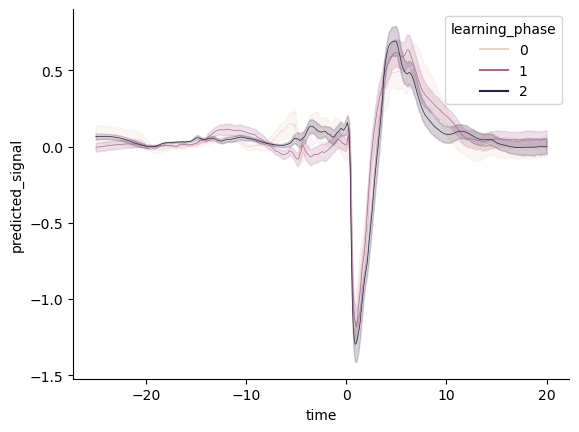

In [19]:



sns.lineplot(data = test_data_query, x = 'time', y = 'predicted_signal', linewidth = 0.5, hue='learning_phase')
# sns.lineplot(data = control_validation_data, x = 'time', y = 'actual_val_signal', label = 'actual', linewidth = 0.5, hue='learning_phase')
    
sns.despine()
# plt.set_ylim(-1.5, 1.5)
# plt.set_xlim(-25, 20)
# plt.set_title(f'Day: {day}, Event: {event}, Sensor: {sensor}')
# plt.set_ylabel('Z-score')
# plt.set_xlabel('Time (s)')
# legend = plt.legend(loc = "upper left", fontsize = 8, frameon = False)
    

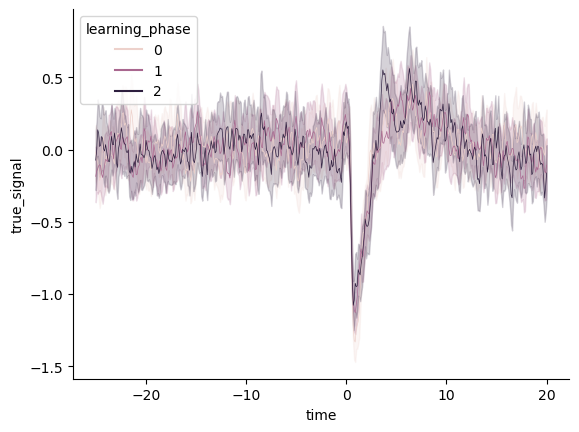

In [20]:
sns.lineplot(data = test_data_query, x = 'time', y = 'true_signal', linewidth = 0.5, hue='learning_phase')
# sns.lineplot(data = control_validation_data, x = 'time', y = 'actual_val_signal', label = 'actual', linewidth = 0.5, hue='learning_phase')
    
sns.despine()

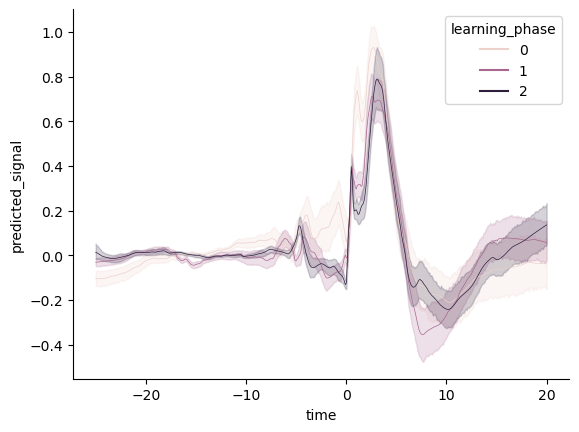

In [24]:
test_data_query_D2 = full_test_data.query("sex_M==1 & event_cue==1 & sensor_D2==1")
sns.lineplot(data = test_data_query_D1, x = 'time', y = 'predicted_signal', linewidth = 0.5, hue='learning_phase')
sns.despine()

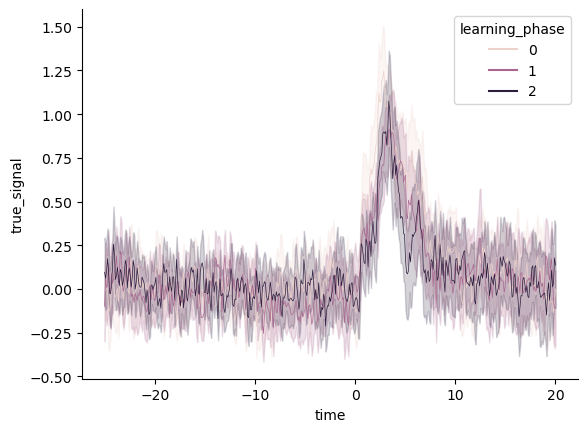

In [25]:
test_data_query_D2 = full_test_data.query("sex_M==1 & event_cue==1 & sensor_D2==1")
sns.lineplot(data = test_data_query_D1, x = 'time', y = 'true_signal', linewidth = 0.5, hue='learning_phase')
sns.despine()

# Results for day 6 and day 7 with cue and shock for each sensor

# Conclusions 



# Next steps